In [1]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.generalized_linear_model import GLM
import numpy as np
import warnings

In [2]:
# Read train and validation data
train = pd.read_csv("/Users/jinwoolee/Downloads/Bank Project/insurance_t_bin.csv")
val = pd.read_csv("/Users/jinwoolee/Downloads/Bank Project/insurance_v_bin.csv")

# EDA Cont.

In [3]:
# First ten observations of train
train.head(10)

# The continuous variables from the previous phase has been strategically binned
# Now, we do not have to deal with the linearity assumption

,DDA,CASHBK,DIRDEP,NSF,SAV,ATM,CD,IRA,LOC,INV,...,INVBAL_Bin,ILSBAL_Bin,MMBAL_Bin,MTGBAL_Bin,CCBAL_Bin,INCOME_Bin,LORES_Bin,HMVAL_Bin,AGE_Bin,CRSCORE_Bin
0,1,0,1,0,0,1,0,0,0,0.0,...,1,1,1,1,1,2,2,1,4,3
1,0,0,0,0,0,0,0,0,0,0.0,...,1,1,1,1,1,2,2,1,4,2
2,1,0,1,0,0,0,0,0,0,0.0,...,1,1,1,1,2,2,1,2,4,3
3,1,0,0,1,1,1,0,0,0,NaN,...,1,1,1,1,3,2,1,2,3,2
4,1,0,0,1,1,1,1,0,0,NaN,...,1,1,1,1,3,2,2,1,4,3
5,0,0,0,0,1,1,0,0,0,NaN,...,1,1,2,1,3,2,2,1,4,3
6,1,0,0,1,1,0,0,0,0,NaN,...,1,1,1,2,3,2,2,2,4,2
7,0,0,0,0,1,0,0,0,1,NaN,...,1,1,1,2,3,2,1,1,4,2
8,1,0,1,0,0,0,0,0,0,0.0,...,1,1,1,1,1,2,2,3,3,2
9,0,0,0,0,1,0,0,1,0,NaN,...,1,1,1,1,3,2,1,1,4,3


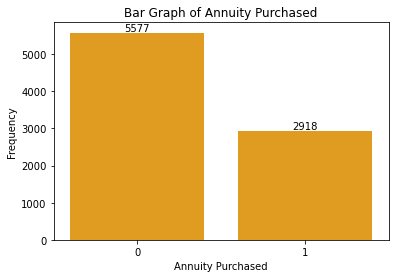

In [4]:
# Explore target variable
ins_counts = train['INS'].value_counts()

ax = sns.countplot(x = "INS", data = train, color = "orange")
ax.set(xlabel = 'Annuity Purchased',
       ylabel = 'Frequency',
       title = 'Bar Graph of Annuity Purchased')
for i, count in enumerate(ins_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.show()

### Missing Values

* Investigate each variable and identify the missing values
* Since all the variables are categorical, change the data to include a missing category

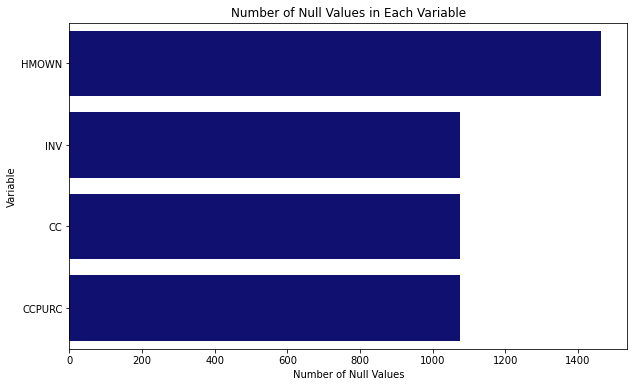

,Variable,Null_Count
3,HMOWN,1463
0,INV,1075
1,CC,1075
2,CCPURC,1075


In [5]:
#Find null values
var_with_null = {'Variable': [], 'Null_Count': []}

# Check all variables
for column in train.columns:
    null_count = train[column].isnull().sum()
    if null_count > 0:
        var_with_null['Variable'].append(column)
        var_with_null['Null_Count'].append(null_count)

var_with_null = pd.DataFrame(var_with_null).sort_values(by = 'Null_Count', ascending = False)

# Plot of the number of null values
plt.figure(figsize=(10, 6))
sns.barplot(x = 'Null_Count', y = 'Variable', data = var_with_null, color = 'navy')
plt.title('Number of Null Values in Each Variable')
plt.xlabel('Number of Null Values')
plt.ylabel('Variable')
plt.show()

var_with_null

In [6]:
# Investigate what the values of these variables are
print(f"HMOWN values: {train['HMOWN'].unique()}")
print(f"INV values: {train['INV'].unique()}")
print(f"CC values: {train['CC'].unique()}")
print(f"CCPURC values: {train['CCPURC'].unique()}")

# Change the data to include a missing category
train['INV'] = train['INV'].fillna('MISSING')
train['CC'] = train['CC'].fillna('MISSING')
train['CCPURC'] = train['CCPURC'].fillna('MISSING')
train['HMOWN'] = train['HMOWN'].fillna('MISSING')

HMOWN values: [ 1.  0. nan]
INV values: [ 0. nan  1.]
CC values: [ 1. nan  0.]
CCPURC values: [ 1.  0. nan  2.  3.  4.]


### Separation Concerns

* Investigate each variable and identify which have **quasi-complete** or **complete separation**
* For **ordinal variables**, we can combine separation categories with categories on either side
* For **nominal variables**, we can combine the separation causing category with the category that has the relationship with the target variable that is the most similar

In [7]:
# Iterate over each column (variable) in the DataFrame
for column in train.columns:
    if column == 'INS':
        continue
    # Calculate the cross-tabulation of 'INS' and the current variable
    cross_tab = pd.crosstab(train[column], train['INS'])
    # Iterate over each cell in the cross-tabulation
    for index, row in cross_tab.iterrows():
        for col in cross_tab.columns:
            if cross_tab.at[index, col] == 0:
                display(cross_tab)

INS,0,1
CASHBK,,
0,5473,2891
1,102,27
2,2,0


INS,0,1
MMCRED,,
0,5409,2713
1,130,153
2,33,47
3,4,5
5,1,0


In [8]:
# Given that we have separation problems for CASHBK and MMCRED, we expect the parameter estimates to be high which checks out
lr_model = GLM.from_formula('INS ~ C(CASHBK) + C(MMCRED)', data = train, family = Binomial()).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    INS   No. Observations:                 8495
Model:                            GLM   Df Residuals:                     8488
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5423.4
Date:                Mon, 15 Apr 2024   Deviance:                       10847.
Time:                        19:25:58   Pearson chi2:                 8.49e+03
No. Iterations:                    20   Pseudo R-squ. (CS):           0.009767
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6805      0.024    -28.742      0.000      -0.727      -0.634
C(CASHBK)[T.1]    -0.6589      0.218     -3.023      0.003      -1.086      -0.232
C(CASHBK)[T.2]   -20.8855   2.07e+04     -0.001      0.999   -4.05e+04    4.05e+04
C(MMCRED)[T.1]     0.8434      0.122      6.936      0.000       0.605       1.082
C(MMCRED)[T.2]     1.0426      0.228      4.563      0.000       0.595       1.490
C(MMCRED)[T.3]     0.9037      0.671      1.346      0.178      -0.412       2.219
C(MMCRED)[T.5]   -20.8855   2.92e+04     -0.001      0.999   -5.73e+04    5.73e+04
==================================================================================
"""

In [9]:
# Since we have quasi-complete separation problems for CASHBK and MMCRED, we combine their categories
train.loc[train['CASHBK'] >= 2, ['CASHBK']] = 1
train.loc[train['MMCRED'] >= 3, ['MMCRED']] = 3

In [10]:
# Now, the parameter estimates are more reasonable
lr_model = GLM.from_formula('INS ~ C(CASHBK) + C(MMCRED)', data = train, family = Binomial()).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    INS   No. Observations:                 8495
Model:                            GLM   Df Residuals:                     8490
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5424.6
Date:                Mon, 15 Apr 2024   Deviance:                       10849.
Time:                        19:25:58   Pearson chi2:                 8.50e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009484
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6805      0.024    -28.742      0.000      -0.727      -0.634
C(CASHBK)[T.1]    -0.6782      0.218     -3.118      0.002      -1.104      -0.252
C(MMCRED)[T.1]     0.8435      0.122      6.936      0.000       0.605       1.082
C(MMCRED)[T.2]     1.0429      0.228      4.564      0.000       0.595       1.491
C(MMCRED)[T.3]     0.6805      0.633      1.075      0.282      -0.560       1.921
==================================================================================
"""

### Multicollinearity

* Investigate Pearson correlation across all pairs of variables through a correlation matrix
* For **highly correlated variables**, consider removing

In [11]:
# Calculate the correlation matrix
correlation_matrix = train.corr()

# Reshape the correlation matrix using pd.melt()
correlation_df = pd.melt(correlation_matrix.reset_index(), id_vars='index', var_name='Variable 2')

# Rename the columns
correlation_df.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Filter out self-correlations
correlation_df = correlation_df[correlation_df['Variable 1'] != correlation_df['Variable 2']]

# Sort the DataFrame by correlation values in descending order
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

# Reset index
correlation_df.reset_index(drop=True, inplace=True)

# Filter out duplicates
correlation_df = correlation_df[correlation_df.index % 2 == 0]

# Filter out correlations less than or equal to 0.9
correlation_df = correlation_df[abs(correlation_df['Correlation']) > 0.9]

correlation_df

,Variable 1,Variable 2,Correlation
0,MM,MMBAL_Bin,1.000000
2,POSAMT_Bin,POS_Bin,0.953615
4,MTG,MTGBAL_Bin,0.946694
6,IRABAL_Bin,IRA,0.934687
8,CDBAL_Bin,CD,0.928902
10,LOC,LOCBAL_Bin,0.915904


In [12]:
# Investigate the MM and MMBAL_Bin variables further
print(train['MM'].unique())
print(train['MMBAL_Bin'].unique())
print((train['MM'] == train['MMBAL_Bin']-1).value_counts())

# These two variables show the same information so the correlation value of 1 checks out

# Remove the MMBAL_Bin variables
train = train.drop(['MMBAL_Bin'], axis = 1)

train

[0 1]
[1 2]
True    8495
dtype: int64


,DDA,CASHBK,DIRDEP,NSF,SAV,ATM,CD,IRA,LOC,INV,...,LOCBAL_Bin,INVBAL_Bin,ILSBAL_Bin,MTGBAL_Bin,CCBAL_Bin,INCOME_Bin,LORES_Bin,HMVAL_Bin,AGE_Bin,CRSCORE_Bin
0,1,0,1,0,0,1,0,0,0,0.0,...,1,1,1,1,1,2,2,1,4,3
1,0,0,0,0,0,0,0,0,0,0.0,...,1,1,1,1,1,2,2,1,4,2
2,1,0,1,0,0,0,0,0,0,0.0,...,1,1,1,1,2,2,1,2,4,3
3,1,0,0,1,1,1,0,0,0,MISSING,...,1,1,1,1,3,2,1,2,3,2
4,1,0,0,1,1,1,1,0,0,MISSING,...,1,1,1,1,3,2,2,1,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,1,0,0,1,0,1,0,0,1,0.0,...,3,1,2,1,2,2,1,2,3,3
8491,1,0,1,0,0,1,0,0,0,0.0,...,1,1,1,1,1,1,1,5,1,3
8492,1,0,1,0,0,0,0,0,1,0.0,...,3,1,1,1,2,2,2,4,4,3
8493,0,0,0,0,0,0,0,0,0,0.0,...,1,1,1,1,1,2,2,2,3,2


# Logistic Regression Model

In [13]:
# For the variables that had 'Missing' imputed for missing values, change the type to str
train[['INV', 'CC', 'CCPURC', 'HMOWN']] = train[['INV', 'CC', 'CCPURC', 'HMOWN']].astype(str)

# Iterate over columns and replace string values with integers
for column in train.columns:
    if train[column].dtype == 'object':
        train[column] = train[column].str.replace('.0', '', regex = False)

# Convert all predictor variables to categorical data type
predictors = [col for col in train.columns if col != 'INS']
train[predictors] = train[predictors].astype('category')

# Create dummy variables for categorical variables
train_dummy = pd.get_dummies(train.drop(columns=['INS']), drop_first=True)

# Create the formula for the predictor variables
predictors = [column for column in train_dummy.columns if column != 'CCPURC_4']  # Remove dummy variable CCPURC_4 due to separation issues
predictors_formula = ' + '.join([predictor for predictor in predictors])

# Add target variable back into train_dummy
train_dummy['INS'] = train['INS']
del train_dummy['CCPURC_4']  # Remove dummy variable CCPURC_4 due to separation issues

# Main effects only binary logistic regression model
lr_model = GLM.from_formula('INS ~ {}'.format(predictors_formula), data = train_dummy, family = Binomial()).fit()
print("The main effects model's AIC is " + str(lr_model.aic))
lr_model.summary()

The main effects model's AIC is 8857.977953745833


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    INS   No. Observations:                 8495
Model:                            GLM   Df Residuals:                     8394
Model Family:                Binomial   Df Model:                          100
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4328.0
Date:                Mon, 15 Apr 2024   Deviance:                       8656.0
Time:                        19:26:00   Pearson chi2:                 8.46e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2349
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.5138      1.225     -2.052      0.040      -4.915      -0.113
DDA_1             -1.5896      0.448     -3.549      0.000      -2.468      -0.712
CASHBK_1          -0.0706      0.240     -0.294      0.769      -0.541       0.400
DIRDEP_1          -0.1451      0.068     -2.132      0.033      -0.279      -0.012
NSF_1              0.6355      0.171      3.721      0.000       0.301       0.970
SAV_1             -0.5030      0.340     -1.481      0.139      -1.169       0.163
ATM_1             -0.0951      0.163     -0.583      0.560      -0.415       0.225
CD_1              -0.0364      0.547     -0.067      0.947      -1.109       1.036
IRA_1              0.6341      0.315      2.012      0.044       0.016       1.252
LOC_1             -0.2949      0.321     -0.919      0.358      -0.924       0.334
INV_1              0.8725      0.221      3.954      0.000       0.440       1.305
INV_MISSING       -0.0522      0.019     -2.705      0.007      -0.090      -0.014
ILS_1             -0.5867      0.308     -1.907      0.056      -1.190       0.016
MM_1               0.8253      0.099      8.343      0.000       0.631       1.019
MMCRED_1          -0.1904      0.160     -1.189      0.235      -0.504       0.124
MMCRED_2           0.0397      0.261      0.152      0.879      -0.472       0.551
MMCRED_3          -0.6803      0.706     -0.964      0.335      -2.064       0.703
MTG_1              1.5203      1.320      1.152      0.249      -1.066       4.107
CC_1               0.2460      0.100      2.450      0.014       0.049       0.443
CC_MISSING        -0.0522      0.019     -2.705      0.007      -0.090      -0.014
CCPURC_1           0.1327      0.099      1.347      0.178      -0.060       0.326
CCPURC_2           0.2094      0.207      1.011      0.312      -0.197       0.616
CCPURC_3          -0.4557      0.452     -1.009      0.313      -1.341       0.430
CCPURC_MISSING    -0.0522      0.019     -2.705      0.007      -0.090      -0.014
SDB_1              0.0538      0.085      0.629      0.529      -0.114       0.221
HMOWN_1           -0.0263      0.078     -0.336      0.737      -0.180       0.127
HMOWN_MISSING     -0.1060      0.321     -0.331      0.741      -0.734       0.522
MOVED_1           -0.2357      0.171     -1.375      0.169      -0.571       0.100
INAREA_1          -0.0689      0.141     -0.490      0.624      -0.344       0.206
BRANCH_B10         0.0901      0.274      0.329      0.742      -0.447       0.627
BRANCH_B11         0.1437      0.328      0.438      0.661      -0.499       0.786
BRANCH_B12         0.3022      0.224      1.348      0.178      -0.137       0.742
BRANCH_B13         0.1523      0.216      0.703      0.482      -0.272       0.577
BRANCH_B14        -0.5887      0.159     -3.692      0.000      -0.901      -0.276
BRANCH_B15  

### Backwards Elimination

* Use backwards elimination to conduct variable selection
* Can utilize AIC, BIC, or p-values for this process

In [14]:
warnings.filterwarnings("ignore")

# Extract the initial AIC value
initial_aic = lr_model.aic

# Initialize variables
best_aic = initial_aic
current_aic = initial_aic
best_formula = predictors_formula
current_formula = predictors_formula

# Perform backward elimination based on AIC
while True:
    feature_removed = None
    features = current_formula.split(' + ')

    # Iterate through every variable in the current list of variables
    for feature in features:
        temp_features = features[:]
        temp_features.remove(feature)
        temp_formula = ' + '.join(temp_features)
        temp_model = GLM.from_formula('INS ~ {}'.format(temp_formula), data = train_dummy, family = Binomial()).fit()

        # Update model if the model without the feature has a lower AIC than the current model's AIC
        if temp_model.aic < best_aic:
            best_aic = temp_model.aic
            best_formula = temp_formula
            feature_removed = feature
            
    # End loop when removing a feature no longer lowers the AIC
    if feature_removed is None:
        break

    #Update the formula and AIC
    current_formula = best_formula
    current_aic = best_aic

# Refit the model that we got after backwards elimination
backwards_formula = current_formula
backwards_model = GLM.from_formula('INS ~ {}'.format(backwards_formula), data = train_dummy, family = Binomial()).fit()

# Model after completing backwards selection
print('Final selected features: ' + backwards_formula)
print("The model's AIC after backwards elimination is " + str(current_aic))
backwards_model.summary()

Final selected features: DDA_1 + DIRDEP_1 + NSF_1 + SAV_1 + ATM_1 + IRA_1 + LOC_1 + INV_1 + INV_MISSING + ILS_1 + MM_1 + MMCRED_1 + MTG_1 + CC_1 + CCPURC_1 + CCPURC_MISSING + BRANCH_B12 + BRANCH_B14 + BRANCH_B15 + BRANCH_B16 + BRANCH_B18 + BRANCH_B19 + BRANCH_B2 + RES_U + DDABAL_Bin_3 + DDABAL_Bin_4 + DDABAL_Bin_5 + DDABAL_Bin_6 + DDABAL_Bin_7 + DDABAL_Bin_8 + ACCTAGE_Bin_2 + CHECKS_Bin_4 + NSFAMT_Bin_2 + PHONE_Bin_3 + PHONE_Bin_4 + TELLER_Bin_2 + TELLER_Bin_3 + SAVBAL_Bin_4 + SAVBAL_Bin_5 + SAVBAL_Bin_6 + SAVBAL_Bin_7 + ATMAMT_Bin_3 + POS_Bin_3 + POSAMT_Bin_3 + CDBAL_Bin_2 + CDBAL_Bin_3 + INVBAL_Bin_3 + MTGBAL_Bin_2 + MTGBAL_Bin_3 + CCBAL_Bin_3 + INCOME_Bin_2 + INCOME_Bin_3 + HMVAL_Bin_3 + HMVAL_Bin_4 + HMVAL_Bin_5
The model's AIC after backwards elimination is 8778.98361909804


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    INS   No. Observations:                 8495
Model:                            GLM   Df Residuals:                     8445
Model Family:                Binomial   Df Model:                           49
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4339.5
Date:                Mon, 15 Apr 2024   Deviance:                       8679.0
Time:                        20:41:06   Pearson chi2:                 8.45e+03
No. Iterations:                    63   Pseudo R-squ. (CS):             0.2328
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.5601      1.186     -2.159      0.031      -4.884      -0.236
DDA_1             -1.3998      0.136    -10.284      0.000      -1.667      -1.133
DIRDEP_1          -0.1476      0.066     -2.220      0.026      -0.278      -0.017
NSF_1              0.6064      0.169      3.582      0.000       0.275       0.938
SAV_1             -0.4257      0.106     -4.003      0.000      -0.634      -0.217
ATM_1             -0.1171      0.063     -1.851      0.064      -0.241       0.007
IRA_1              0.4801      0.113      4.266      0.000       0.260       0.701
LOC_1             -0.1798      0.112     -1.601      0.109      -0.400       0.040
INV_1              0.7567      0.191      3.958      0.000       0.382       1.131
INV_MISSING       -0.0687      0.018     -3.903      0.000      -0.103      -0.034
ILS_1             -0.4927      0.130     -3.789      0.000      -0.748      -0.238
MM_1               0.8255      0.092      8.977      0.000       0.645       1.006
MMCRED_1          -0.1752      0.156     -1.120      0.263      -0.482       0.131
MTG_1              1.4688      1.290      1.139      0.255      -1.059       3.997
CC_1               0.2991      0.063      4.723      0.000       0.175       0.423
CCPURC_1           0.1377      0.097      1.419      0.156      -0.052       0.328
CCPURC_MISSING    -0.0687      0.018     -3.903      0.000      -0.103      -0.034
BRANCH_B12         0.2608      0.206      1.266      0.205      -0.143       0.664
BRANCH_B14        -0.5875      0.159     -3.699      0.000      -0.899      -0.276
BRANCH_B15        -0.2242      0.123     -1.816      0.069      -0.466       0.018
BRANCH_B16        -0.7363      0.142     -5.168      0.000      -1.016      -0.457
BRANCH_B18         0.3861      0.169      2.283      0.022       0.055       0.717
BRANCH_B19         0.3569      0.222      1.609      0.108      -0.078       0.791
BRANCH_B2         -0.1462      0.080     -1.819      0.069      -0.304       0.011
RES_U             -0.0795      0.055     -1.447      0.148      -0.187       0.028
DDABAL_Bin_3       0.2993      0.145      2.063      0.039       0.015       0.584
DDABAL_Bin_4       0.6013      0.135      4.445      0.000       0.336       0.866
DDABAL_Bin_5       0.8691      0.141      6.156      0.000       0.592       1.146
DDABAL_Bin_6       1.1381      0.137      8.300      0.000       0.869       1.407
DDABAL_Bin_7       1.3959      0.137     10.182      0.000       1.127       1.665
DDABAL_Bin_8       1.9382      0.155     12.504      0.000       1.634       2.242
ACCTAGE_Bin_2     -0.1794      0.121     -1.485      0.138      -0.416       0.057
CHECKS_Bin_4      -0.5514      0.069     -7.982      0.000      -0.687      -0.416
NSFAMT_Bin_2      -0.3476      0.203     -1.714      0.086      -0.745       0.050
PHONE_Bin_3 

### Interaction Terms

* Investigate all two-way interaction terms to see if a change in one predictor affects the relationship between another predictor and the target 

In [15]:
warnings.filterwarnings("ignore")

# Investigate possible interations between predictors
interactions_model = GLM.from_formula('INS ~ (' + backwards_formula + ')**2', data=train_dummy, family=Binomial()).fit()

# Extract all possible interaction terms
interactions_formula = interactions_model.model.exog_names
interactions_formula.remove('Intercept')
interactions_formula = ' + '.join([predictor for predictor in interactions_formula])

### Forward Selection for Interaction Terms

* Investigate if adding any interaction terms will allow the model to capture the more complex relationships between predictors and the target variable

In [16]:
warnings.filterwarnings("ignore")

# Initialize the best AIC value and the best formula
best_aic = backwards_model.aic
best_formula = backwards_formula
backwards_terms = backwards_formula.split(' + ')

# Initialize a list to keep track of added predictors
added_predictors = []

# Perform forward selection based on AIC
while True:
    best_aic_candidate = None
    best_candidate = None
    interactions_terms = interactions_formula.split(' + ')
    features = [x for x in interactions_terms if x not in backwards_terms]
    for feature in features:
        if feature not in added_predictors:
            candidate_formula = best_formula + f" + {feature}"
            candidate_model = GLM.from_formula('INS ~ {}'.format(candidate_formula), data = train_dummy, family = Binomial()).fit()
            candidate_aic = candidate_model.aic
            if best_aic_candidate is None or candidate_aic < best_aic_candidate:
                best_aic_candidate = candidate_aic
    if best_aic_candidate is not None and best_aic_candidate < best_aic:
        best_aic = best_aic_candidate
        best_formula = candidate_formula
        added_predictors.append(candidate_formula.split(' + ')[-1])
    else:
        break

# Fit the model with the selected predictors
final_model = GLM.from_formula('INS ~ {}'.format(best_formula), data = train_dummy, family = Binomial()).fit()

# Print the summary of the interactions model
print('Final selected features: ' + best_formula)
print("The model's AIC after forward selection (interaction terms) is " + str(best_aic))
final_model.summary()

# As the coefficient estimates, standard errors, z-values, p-values, and confidence intervals for these interaction terms are all reported as 0 or NaN,
# we will not consider them for the final model

Final selected features: DDA_1 + DIRDEP_1 + NSF_1 + SAV_1 + ATM_1 + IRA_1 + LOC_1 + INV_1 + INV_MISSING + ILS_1 + MM_1 + MMCRED_1 + MTG_1 + CC_1 + CCPURC_1 + CCPURC_MISSING + BRANCH_B12 + BRANCH_B14 + BRANCH_B15 + BRANCH_B16 + BRANCH_B18 + BRANCH_B19 + BRANCH_B2 + RES_U + DDABAL_Bin_3 + DDABAL_Bin_4 + DDABAL_Bin_5 + DDABAL_Bin_6 + DDABAL_Bin_7 + DDABAL_Bin_8 + ACCTAGE_Bin_2 + CHECKS_Bin_4 + NSFAMT_Bin_2 + PHONE_Bin_3 + PHONE_Bin_4 + TELLER_Bin_2 + TELLER_Bin_3 + SAVBAL_Bin_4 + SAVBAL_Bin_5 + SAVBAL_Bin_6 + SAVBAL_Bin_7 + ATMAMT_Bin_3 + POS_Bin_3 + POSAMT_Bin_3 + CDBAL_Bin_2 + CDBAL_Bin_3 + INVBAL_Bin_3 + MTGBAL_Bin_2 + MTGBAL_Bin_3 + CCBAL_Bin_3 + INCOME_Bin_2 + INCOME_Bin_3 + HMVAL_Bin_3 + HMVAL_Bin_4 + HMVAL_Bin_5 + HMVAL_Bin_4:HMVAL_Bin_5 + HMVAL_Bin_3:HMVAL_Bin_5
The model's AIC after forward selection (interaction terms) is 8741.994454410979


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    INS   No. Observations:                 8495
Model:                            GLM   Df Residuals:                     8445
Model Family:                Binomial   Df Model:                           49
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4339.5
Date:                Mon, 15 Apr 2024   Deviance:                       8679.0
Time:                        21:48:06   Pearson chi2:                 8.45e+03
No. Iterations:                    63   Pseudo R-squ. (CS):             0.2328
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.5601      1.186     -2.159      0.031      -4.884      -0.236
DDA_1                      -1.3998      0.136    -10.284      0.000      -1.667      -1.133
DIRDEP_1                   -0.1476      0.066     -2.220      0.026      -0.278      -0.017
NSF_1                       0.6064      0.169      3.582      0.000       0.275       0.938
SAV_1                      -0.4257      0.106     -4.003      0.000      -0.634      -0.217
ATM_1                      -0.1171      0.063     -1.851      0.064      -0.241       0.007
IRA_1                       0.4801      0.113      4.266      0.000       0.260       0.701
LOC_1                      -0.1798      0.112     -1.601      0.109      -0.400       0.040
INV_1                       0.7567      0.191      3.958      0.000       0.382       1.131
INV_MISSING                -0.0687      0.018     -3.903      0.000      -0.103      -0.034
ILS_1                      -0.4927      0.130     -3.789      0.000      -0.748      -0.238
MM_1                        0.8255      0.092      8.977      0.000       0.645       1.006
MMCRED_1                   -0.1752      0.156     -1.120      0.263      -0.482       0.131
MTG_1                       1.4688      1.290      1.139      0.255      -1.059       3.997
CC_1                        0.2991      0.063      4.723      0.000       0.175       0.423
CCPURC_1                    0.1377      0.097      1.419      0.156      -0.052       0.328
CCPURC_MISSING             -0.0687      0.018     -3.903      0.000      -0.103      -0.034
BRANCH_B12                  0.2608      0.206      1.266      0.205      -0.143       0.664
BRANCH_B14                 -0.5875      0.159     -3.699      0.000      -0.899      -0.276
BRANCH_B15                 -0.2242      0.123     -1.816      0.069      -0.466       0.018
BRANCH_B16                 -0.7363      0.142     -5.168      0.000      -1.016      -0.457
BRANCH_B18                  0.3861      0.169      2.283      0.022       0.055       0.717
BRANCH_B19                  0.3569      0.222      1.609      0.108      -0.078       0.791
BRANCH_B2                  -0.1462      0.080     -1.819      0.069      -0.304       0.011
RES_U                      -0.0795      0.055     -1.447      0.148      -0.187       0.028
DDABAL_Bin_3                0.2993      0.145      2.063      0.039       0.015       0.584
DDABAL_Bin_4                0.6013      0.135      4.445      0.000       0.336       0.866
DDABAL_Bin_5                0.8691      0.141      6.156      0.000       0.592       1.146
DDABAL_Bin_6                1.1381      0.137      8.300      0.000       0.869       1.407
DDABAL_Bin_7                1.3959      0.137     10.182      0.000       1.127       1.665
DDABAL_Bin_8                1.9382      0.155  

In [17]:
# Final model
best_formula = best_formula.split(' + ')
best_formula = best_formula[:-2]
best_formula = ' + '.join(best_formula)

logistic_regression_model = GLM.from_formula('INS ~ {}'.format(best_formula), data = train_dummy, family = Binomial()).fit()

### Final variables left in the model ranked by p-value

In [18]:
# Extract p-values and coefficients from our final logistic regression model
lr_p_values = logistic_regression_model.pvalues.drop('Intercept')  # Exclude intercept
lr_coefficients = logistic_regression_model.params.drop('Intercept')  # Exclude intercept

# Create a DataFrame with variable names and p-values
final_p_values = pd.DataFrame({'P-Value': lr_p_values, 'Coefficient': lr_coefficients})

# Sort the DataFrame by p-values in ascending order
final_p_values = final_p_values.sort_values(by='P-Value')

final_p_values

,P-Value,Coefficient
SAVBAL_Bin_7,1.542491e-59,2.150262
SAVBAL_Bin_6,2.372980e-40,1.727171
DDABAL_Bin_8,7.077170e-36,1.938225
CDBAL_Bin_3,4.873379e-30,1.430784
DDA_1,8.315270e-25,-1.399800
DDABAL_Bin_7,2.375865e-24,1.395858
SAVBAL_Bin_5,1.551920e-22,1.290678
MM_1,2.791225e-19,0.825498
DDABAL_Bin_6,1.040222e-16,1.138099
CHECKS_Bin_4,1.444754e-15,-0.551403


### Revisit odds ratio

In [19]:
# Odds Ratio for the variable with the lowest p-value from the final model
np.exp(final_p_values.loc['SAVBAL_Bin_7','Coefficient'])


# Customers with savings account balances greater than $8,000 are 8.6 times more likely
# to purchase the annuity product than those with savings account balances of at most $8,000.

8.587109807955246